In [1]:
import torch
import pandas as pd
from tqdm.notebook import trange, tqdm
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import numpy as np
from   sklearn.preprocessing   import LabelEncoder          # кодировка категорий
import pandas as pd
from torch.autograd import Variable
import numpy as np
import torch.functional as F
from   sklearn.preprocessing   import LabelEncoder          # кодировка категорий
from   sklearn.decomposition import PCA
from   sklearn import linear_model
import matplotlib.pyplot as plt                   # постороение графиков
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset
import transformers
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors

In [2]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
# Читаем файл с компетенциями
dfHS = pd.read_excel('DATASET_BALANCE_CLASS4.xlsx')

In [4]:
dfHS['SKILLS'] = dfHS['SKILLS'].astype(str)
# Длинна каждого посчитаем длинну
dfHS['list_of_skill'] = dfHS['SKILLS'].apply(lambda x: x.split(','))
dfHS['cnt_skill'] = dfHS['list_of_skill'].apply(lambda x: len(x))

In [5]:
df_skill = dfHS[(dfHS.cnt_skill > 4) & (dfHS.cnt_skill < 16)]

In [6]:
len(df_skill)

16729

In [7]:
embeddings = torch.load('embeddings.pth', map_location=torch.device('cpu'))

In [8]:
embeddings[0]

tensor([9.3875, 9.9098, 9.9899, 9.3184, 6.9727, 0.2576, 9.7376, 8.5665, 5.7270,
        0.7439, 0.3846, 1.0711, 2.6154, 2.1553, 5.0674, 2.9318, 5.4648, 0.7262,
        2.2338, 6.1609, 6.2313, 5.4893, 3.9408, 1.3311])

In [9]:
# Читаем файл с компетенциями
vocab = pd.read_excel('df_vocabulary_tensor.xlsx')

In [10]:
vocab.head(3)

,id_skill,skill
0,0,ЯНДЕКС МЕТРИКА
1,1,КОНТЕКСТНАЯ РЕКЛАМА
2,2,ЯНДЕКС ДИРЕКТ


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hdbscan
from umap import UMAP
from sklearn.cluster import KMeans

embeddings = embeddings.cpu()
# Преобразование тензора embeddings в массив numpy
embeddings_np = embeddings.detach().numpy()

# UMAP 

In [120]:
# Сокращение размерности с помощью UMAP
umap_model_one = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
embeddings_umap_model_one = umap_model_one.fit_transform(embeddings_np)

In [121]:
# Сокращение размерности с помощью UMAP
umap_model_two = UMAP(n_components=2, n_neighbors=10, min_dist=0.01)
embeddings_umap_model_two = umap_model_two.fit_transform(embeddings_np)

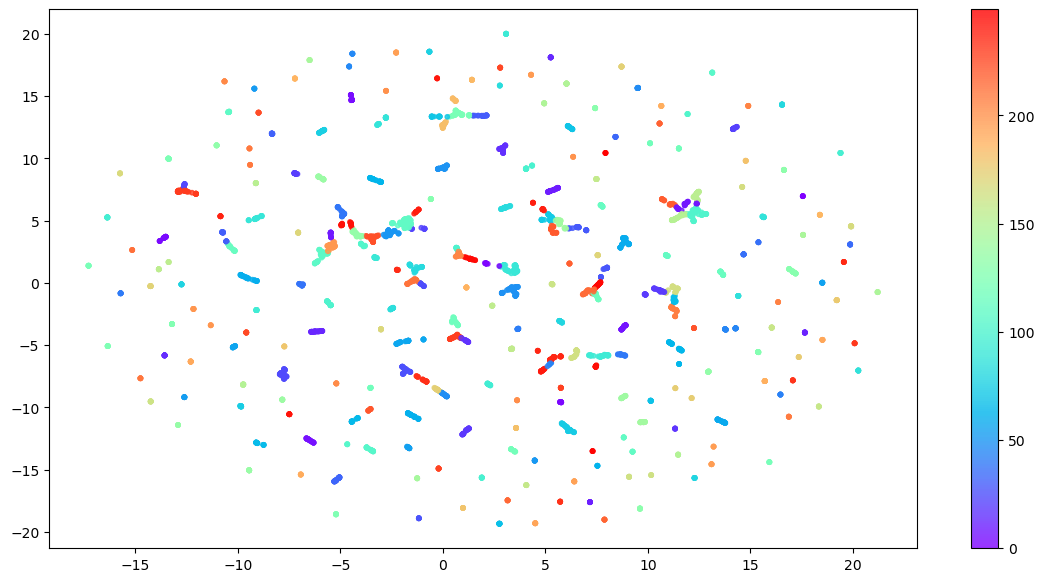

In [145]:
# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=250)  # Укажите желаемое количество кластеров
clusters_one = kmeans.fit_predict(embeddings_umap_model_one)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(embeddings_umap_model_one[:, 0], embeddings_umap_model_one[:, 1], c=clusters_one, cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

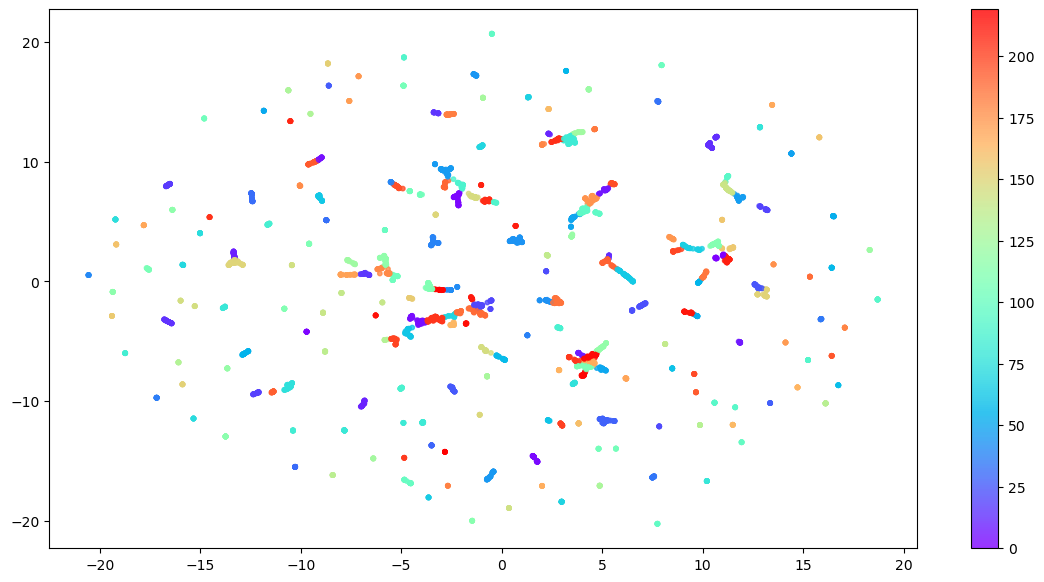

In [146]:
# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=220)  # Укажите желаемое количество кластеров
clusters_two = kmeans.fit_predict(embeddings_umap_model_two)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(embeddings_umap_model_two[:, 0], embeddings_umap_model_two[:, 1], c=clusters_two, cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

In [147]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

# Оценка стабильности кластеров
silhouette = silhouette_score(embeddings_umap_model_one, clusters_one)
dbi = davies_bouldin_score(embeddings_umap_model_one, clusters_one)
ari = adjusted_rand_score(clusters_one, clusters_two)  # Сравниваем кластеризацию с самой собой
ami = adjusted_mutual_info_score(clusters_one, clusters_two)  # Также сравниваем с самой собой

print(f'Silhouette Score: {silhouette}')
print(f"Индекс Дэвиса-Булдина: {dbi}")
print(f'Adjusted Rand Index: {ari}')
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.7881931662559509
Индекс Дэвиса-Булдина: 0.2586667276825348
Adjusted Rand Index: 0.7285117127527829
Adjusted Mutual Information: 0.898949883260267


In [148]:
print(f'Silhouette Score: {format(round(silhouette, 2), ".2f")}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {round(ari, 2)}')
print(f'Adjusted Mutual Information: {round(ami, 2)}')

Silhouette Score: 0.79
Индекс Дэвиса-Булдина: 0.26
Adjusted Rand Index: 0.73
Adjusted Mutual Information: 0.9


In [149]:
# Создание словаря, где ключом будет номер кластера, а значением - список навыков, относящихся к этому кластеру
cluster_skills = {}
for cluster_id in np.unique(clusters_one):
    if cluster_id == -1:
        continue  # Пропускаем шумовой кластер
    
    cluster_indices = np.where(clusters_one == cluster_id)[0]  # Индексы элементов, относящихся к текущему кластеру
    cluster_skills[cluster_id] = cluster_indices

# Создание словаря для соответствия между номерами навыков и их названиями
skills_dict = {row['id_skill']: row['skill'] for idx, row in vocab.iterrows()}

# Вывод названия кластера и всех навыков, входящих в него
for cluster_id, skills_indices in cluster_skills.items():
    print(f"Cluster ID: {cluster_id}")
    print("Skills in the cluster:")
    for idx in skills_indices:
        skill_name = skills_dict.get(idx, "Unknown Skill")
        print(skill_name)
    print("\n")

Cluster ID: 0
Skills in the cluster:
PANDAS
NUMPY
ASYNCIO
DRF
XGBOOST


Cluster ID: 1
Skills in the cluster:
ВЫСОКАЯ СКОРОСТЬ РАБОТЫ
НАХОЖДЕНИЕ ПОДХОДА К КЛИЕНТУ И ДОСТИЖЕНИЕ КОМПРОМИССОВ
СПОСОБНОСТЬ ПРИНИМАТЬ РЕШЕНИЯ
ОРГАНИЗАЦИЯ МЕРОПРИЯТИЙ ДЛЯ СОТРУДНИКОВ
АКТИВНАЯ ЖИЗНЕННАЯ ПОЗИЦИЯ
ОТЛИЧНАЯ ПАМЯТЬ
ОРГАНИЗАЦИОННАЯ ОСВЕДОМЛЕННОСТЬ
ЭМОЦИОНАЛЬНЫЙ ИНТЕЛЛЕКТ
БЫСТРАЯ СКОРОСТЬ ПЕЧАТИ
РАБОТА В 4 РУКИ
СПОСОБНОСТЬ К ОБУЧЕНИЮ


Cluster ID: 2
Skills in the cluster:
БИЗНЕС АНАЛИЗ
BPMN
МОДЕЛИРОВАНИЕ БИЗНЕС ПРОЦЕССОВ
UML
УПРАВЛЕНИЕ БИЗНЕС ПРОЦЕССАМИ
IDEF
DIRECTUM
СИСТЕМНЫЙ АНАЛИЗ
IDEF0
BUSINESS STUDIO
РАЗРАБОТКА РЕГЛАМЕНТОВ
BPM
ВНЕДРЕНИЕ СТАНДАРТОВ ISO
ELMA


Cluster ID: 3
Skills in the cluster:
СМЕТЫ
СОСТАВЛЕНИЕ СМЕТНО ПРОЕКТНОЙ ДОКУМЕНТАЦИИ
СОСТАВЛЕНИЕ СМЕТ
ДОГОВОРЫ ПОДРЯДА
ПОДГОТОВКА СМЕТ
ГРАНД СМЕТА
СМЕТНЫЙ КАЛЬКУЛЯТОР
ИНЖЕНЕР ПТО
SMETA RU
СМЕТНАЯ ДОКУМЕНТАЦИЯ
ТУРБО СМЕТЧИК
ESTIMATE
СМЕТА РУ
SMETAWIZARD
ФЕР
А0
ПРОВЕРКА СМЕТ
ГОССТРОЙСМЕТА
РИК
ДЕЛОВЫЕ КОММУНИКАЦИИ
DIALUX
М 29
ЖИЛИЩНОЕ СТРОИТЕЛЬСТВ

In [131]:
vocab_list = vocab["skill"].to_list()

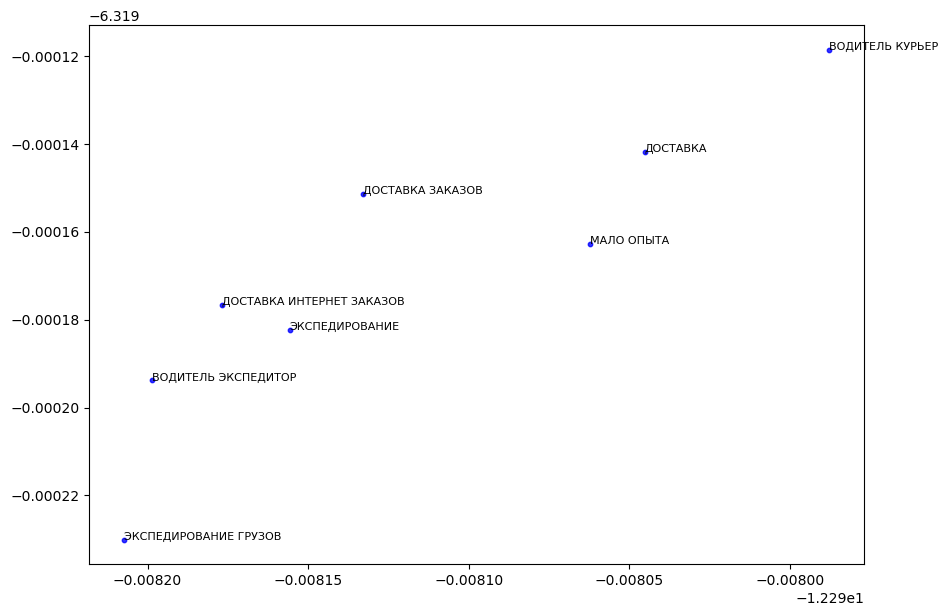

In [144]:
# Список слов для исключения
words_to_exclude = ['КОНСУЛЬТАНТ', 'КУРЬЕР']

# Вывод названий слов в кластере номер 185, исключая определенные слова
cluster185_indices = np.where(clusters_one == 17)[0]
words_in_cluster185 = [vocab_list[idx] for idx in cluster185_indices if vocab_list[idx] not in words_to_exclude]

# Визуализация результатов с названиями слов из кластера 185 (исключая определенные слова)
plt.figure(figsize=(10, 7))

# Отображение только точек из кластера 185 (исключая определенные слова)
for idx in cluster185_indices:
    if vocab_list[idx] not in words_to_exclude:
        plt.scatter(embeddings_umap_model_one[idx, 0], embeddings_umap_model_one[idx, 1], c='blue', s=10, alpha=0.8)
        plt.text(embeddings_umap_model_one[idx, 0], embeddings_umap_model_one[idx, 1], vocab_list[idx], fontsize=8)

plt.show()

Эти метрики оценки качества кластеризации и сравнения различных кластеризаций между собой являются показателями того, насколько хорошо алгоритмы кластеризации справились с задачей разделения данных на группы.

Silhouette Score:
Значение Silhouette Score равное 0.769 указывает на хорошее разделение кластеров в данных. Чем ближе этот коэффициент к 1, тем лучше разделение. Silhouette Score учитывает, насколько объекты похожи на свой кластер по сравнению с другими кластерами.

Adjusted Rand Index (ARI):
Значение ARI равное 0.723 говорит о степени сходства между двумя различными кластеризациями. Он изменяется от -1 до 1, где 1 указывает на идентичные кластеры, а 0 или отрицательное число означает случайное разделение.

Adjusted Mutual Information (AMI):
AMI 0.890 свидетельствует о взаимной информации между двумя различными кластеризациями. Этот показатель указывает на то, насколько информация о разделении кластеров одной системой соответствует информации о кластеризации другой системой.
Таким образом, значения метрик указывают на успешное разделение данных на кластеры и хорошее сходство или взаимную информацию между разными способами кластеризации. Наличие высоких показателей подтверждает качество работы алгоритмов кластеризации в вашем случае.

# #  HDBSCAN

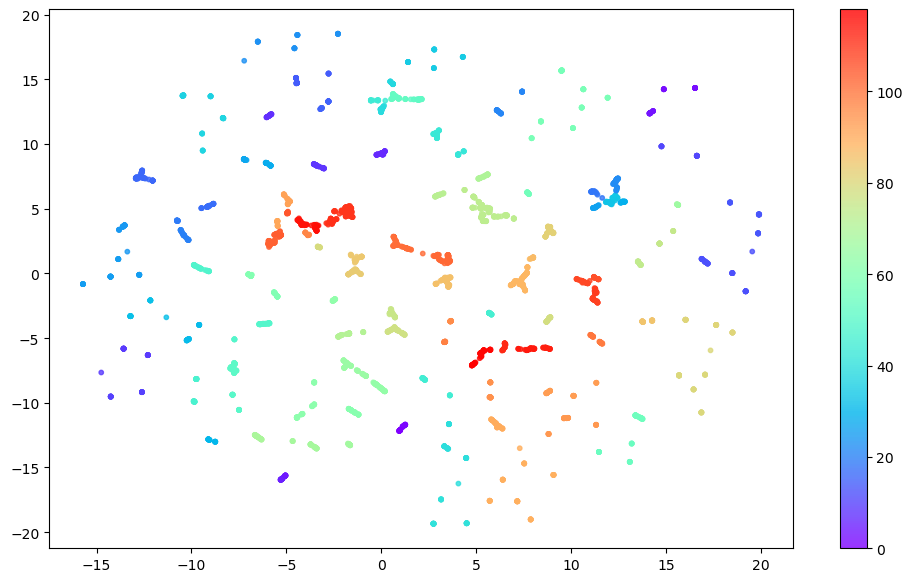

In [150]:
# Кластеризация с помощью HDBSCAN
clusterer_one = hdbscan.HDBSCAN(min_cluster_size=15)
clusters_hdbscan_one = clusterer_one.fit_predict(embeddings_umap_model_one)

# Поиск индексов элементов, относящихся к кластеру -1
indices_to_keep = np.where(clusters_hdbscan_one != -1)[0]

# Фильтрация embeddings_tsne, оставляем только элементы, не относящиеся к кластеру -1
filtered_embeddings_umap_one = embeddings_umap_model_one[indices_to_keep]

# Визуализация результатов
plt.figure(figsize=(12, 7))
plt.scatter(filtered_embeddings_umap_one[:, 0], filtered_embeddings_umap_one[:, 1], c=clusters_hdbscan_one[indices_to_keep], cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

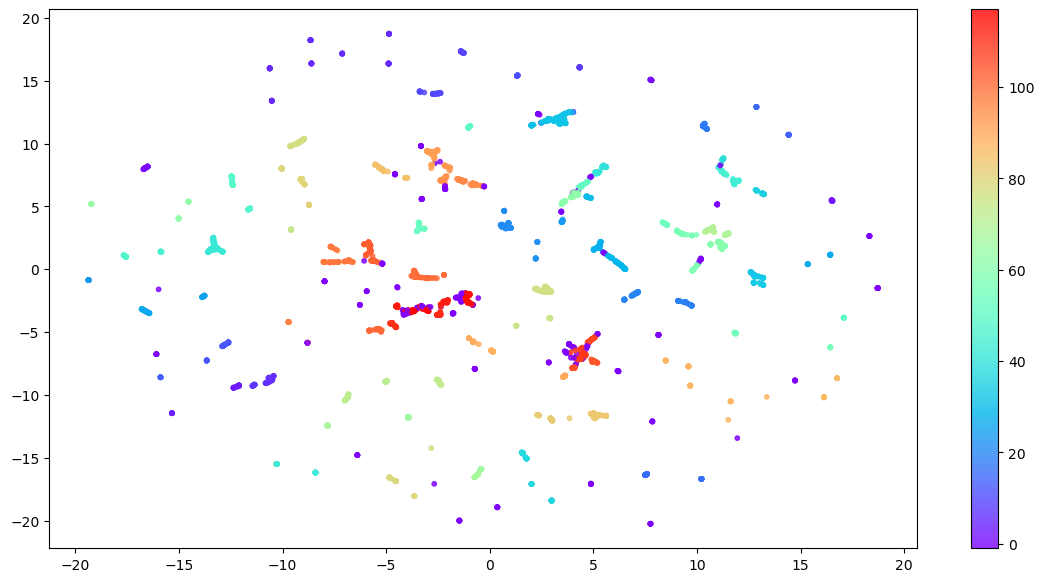

In [151]:
# Кластеризация с помощью HDBSCAN
clusterer_two = hdbscan.HDBSCAN(min_cluster_size=15)
clusters_hdbscan_two = clusterer_one.fit_predict(embeddings_umap_model_two)

# Поиск индексов элементов, относящихся к кластеру -1
indices_to_keep = np.where(clusters_hdbscan_one != -1)[0]

# Фильтрация embeddings_tsne, оставляем только элементы, не относящиеся к кластеру -1
filtered_embeddings_umap_two = embeddings_umap_model_two[indices_to_keep]

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(filtered_embeddings_umap_two[:, 0], filtered_embeddings_umap_two[:, 1], c=clusters_hdbscan_two[indices_to_keep], cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

In [152]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

# Оценка стабильности кластеров
silhouette = silhouette_score(embeddings_umap_model_two, clusters_hdbscan_two)
dbi = davies_bouldin_score(embeddings_umap_model_two, clusters_hdbscan_two)
ari = adjusted_rand_score(clusters_hdbscan_one, clusters_hdbscan_two)  # Сравниваем кластеризацию с самой собой
ami = adjusted_mutual_info_score(clusters_hdbscan_one, clusters_hdbscan_two)  # Также сравниваем с самой собой

print(f'Silhouette Score: {silhouette}')
print(f"Индекс Дэвиса-Булдина: {dbi}")
print(f'Adjusted Rand Index: {ari}')
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.5370070338249207
Индекс Дэвиса-Булдина: 1.1952265833434546
Adjusted Rand Index: 0.2796574681281219
Adjusted Mutual Information: 0.759192038319515


In [153]:
print(f'Silhouette Score: {format(round(silhouette, 2), ".2f")}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {round(ari, 2)}')
print(f'Adjusted Mutual Information: {round(ami, 2)}')

Silhouette Score: 0.54
Индекс Дэвиса-Булдина: 1.2
Adjusted Rand Index: 0.28
Adjusted Mutual Information: 0.76


In [154]:
# Создание словаря, где ключом будет номер кластера, а значением - список навыков, относящихся к этому кластеру
cluster_skills = {}
for cluster_id in np.unique(clusters_hdbscan_two):
    if cluster_id == -1:
        continue  # Пропускаем шумовой кластер
    
    cluster_indices = np.where(clusters_one == cluster_id)[0]  # Индексы элементов, относящихся к текущему кластеру
    cluster_skills[cluster_id] = cluster_indices

# Создание словаря для соответствия между номерами навыков и их названиями
skills_dict = {row['id_skill']: row['skill'] for idx, row in vocab.iterrows()}

# Вывод названия кластера и всех навыков, входящих в него
for cluster_id, skills_indices in cluster_skills.items():
    print(f"Cluster ID: {cluster_id}")
    print("Skills in the cluster:")
    for idx in skills_indices:
        skill_name = skills_dict.get(idx, "Unknown Skill")
        print(skill_name)
    print("\n")

Cluster ID: 0
Skills in the cluster:
PANDAS
NUMPY
ASYNCIO
DRF
XGBOOST


Cluster ID: 1
Skills in the cluster:
ВЫСОКАЯ СКОРОСТЬ РАБОТЫ
НАХОЖДЕНИЕ ПОДХОДА К КЛИЕНТУ И ДОСТИЖЕНИЕ КОМПРОМИССОВ
СПОСОБНОСТЬ ПРИНИМАТЬ РЕШЕНИЯ
ОРГАНИЗАЦИЯ МЕРОПРИЯТИЙ ДЛЯ СОТРУДНИКОВ
АКТИВНАЯ ЖИЗНЕННАЯ ПОЗИЦИЯ
ОТЛИЧНАЯ ПАМЯТЬ
ОРГАНИЗАЦИОННАЯ ОСВЕДОМЛЕННОСТЬ
ЭМОЦИОНАЛЬНЫЙ ИНТЕЛЛЕКТ
БЫСТРАЯ СКОРОСТЬ ПЕЧАТИ
РАБОТА В 4 РУКИ
СПОСОБНОСТЬ К ОБУЧЕНИЮ


Cluster ID: 2
Skills in the cluster:
БИЗНЕС АНАЛИЗ
BPMN
МОДЕЛИРОВАНИЕ БИЗНЕС ПРОЦЕССОВ
UML
УПРАВЛЕНИЕ БИЗНЕС ПРОЦЕССАМИ
IDEF
DIRECTUM
СИСТЕМНЫЙ АНАЛИЗ
IDEF0
BUSINESS STUDIO
РАЗРАБОТКА РЕГЛАМЕНТОВ
BPM
ВНЕДРЕНИЕ СТАНДАРТОВ ISO
ELMA


Cluster ID: 3
Skills in the cluster:
СМЕТЫ
СОСТАВЛЕНИЕ СМЕТНО ПРОЕКТНОЙ ДОКУМЕНТАЦИИ
СОСТАВЛЕНИЕ СМЕТ
ДОГОВОРЫ ПОДРЯДА
ПОДГОТОВКА СМЕТ
ГРАНД СМЕТА
СМЕТНЫЙ КАЛЬКУЛЯТОР
ИНЖЕНЕР ПТО
SMETA RU
СМЕТНАЯ ДОКУМЕНТАЦИЯ
ТУРБО СМЕТЧИК
ESTIMATE
СМЕТА РУ
SMETAWIZARD
ФЕР
А0
ПРОВЕРКА СМЕТ
ГОССТРОЙСМЕТА
РИК
ДЕЛОВЫЕ КОММУНИКАЦИИ
DIALUX
М 29
ЖИЛИЩНОЕ СТРОИТЕЛЬСТВ

In [116]:
silhouette = silhouette_score(embeddings_umap_model_two, clusters_hdbscan_two)

In [117]:
silhouette

0.51067376

In [37]:
ari = adjusted_rand_score(clusters_one, clusters_hdbscan_two)  # Сравниваем кластеризацию с самой собой
ami = adjusted_mutual_info_score(clusters_one, clusters_hdbscan_two)  # Также сравниваем с самой собой
print(f'Adjusted Rand Index: {ari}')
print(f'Adjusted Mutual Information: {ami}')

Adjusted Rand Index: 0.37111746318714933
Adjusted Mutual Information: 0.7985772228500756


# Сокращение размерности с помощью t-SNE

In [89]:
# Сокращение размерности с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
embeddings_tsne_one = tsne.fit_transform(embeddings_np)

In [90]:
# Сокращение размерности с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=200, learning_rate=200)
embeddings_tsne_two = tsne.fit_transform(embeddings_np)

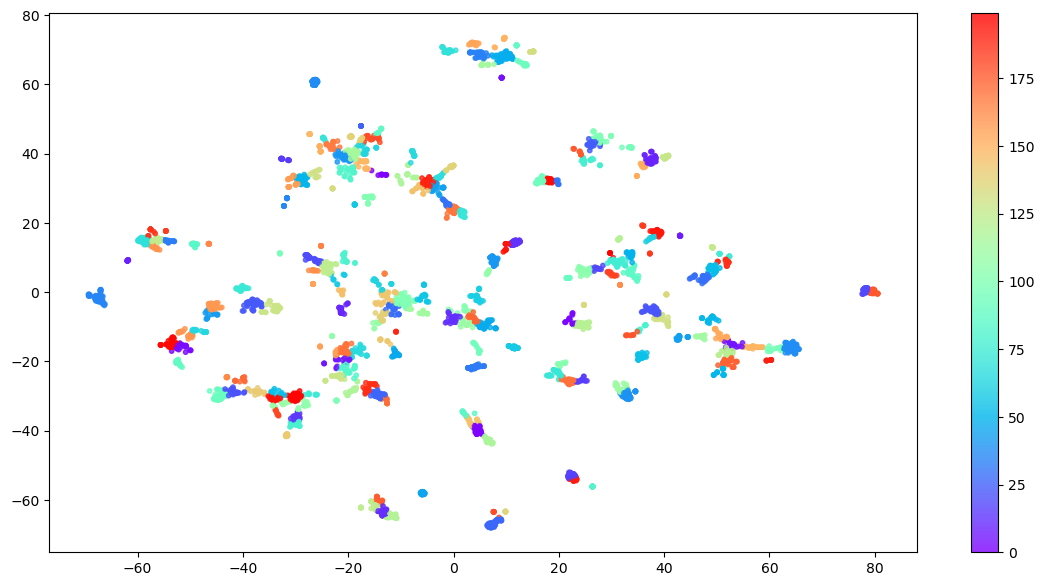

In [91]:
# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=200)  # Укажите желаемое количество кластеров
clusters_tsne_one = kmeans.fit_predict(embeddings_tsne_one)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(embeddings_tsne_one[:, 0], embeddings_tsne_one[:, 1], c=clusters_tsne_one, cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

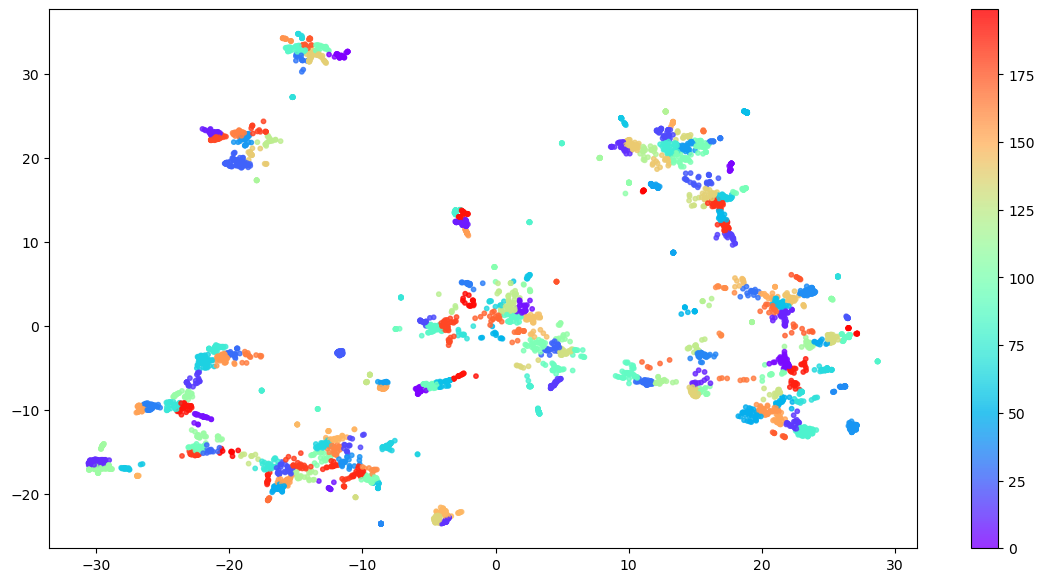

In [92]:
# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=200)  # Укажите желаемое количество кластеров
clusters_tsne_two = kmeans.fit_predict(embeddings_tsne_two)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(embeddings_tsne_two[:, 0], embeddings_tsne_two[:, 1], c=clusters_tsne_two, cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

In [98]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

# Оценка стабильности кластеров
silhouette = silhouette_score(embeddings_tsne_one, clusters_tsne_one)
dbi = davies_bouldin_score(embeddings_tsne_one, clusters_tsne_one)
ari = adjusted_rand_score(clusters_tsne_one, clusters_tsne_two)  # Сравниваем кластеризацию с самой собой
ami = adjusted_mutual_info_score(clusters_tsne_one, clusters_tsne_two)  # Также сравниваем с самой собой

print(f'Silhouette Score: {silhouette}')
print(f"Индекс Дэвиса-Булдина: {dbi}")
print(f'Adjusted Rand Index: {ari}')
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.5820780396461487
Индекс Дэвиса-Булдина: 0.5641538373218635
Adjusted Rand Index: 0.7197777799592607
Adjusted Mutual Information: 0.8670461257880258


In [99]:
print(f'Silhouette Score: {format(round(silhouette, 2), ".2f")}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {round(ari, 2)}')
print(f'Adjusted Mutual Information: {round(ami, 2)}')

Silhouette Score: 0.58
Индекс Дэвиса-Булдина: 0.56
Adjusted Rand Index: 0.72
Adjusted Mutual Information: 0.87


In [95]:
silhouette = silhouette_score(embeddings_tsne_two, clusters_tsne_two)

In [96]:
silhouette

0.5228949

# Кластеризация с помощью HDBSCAN

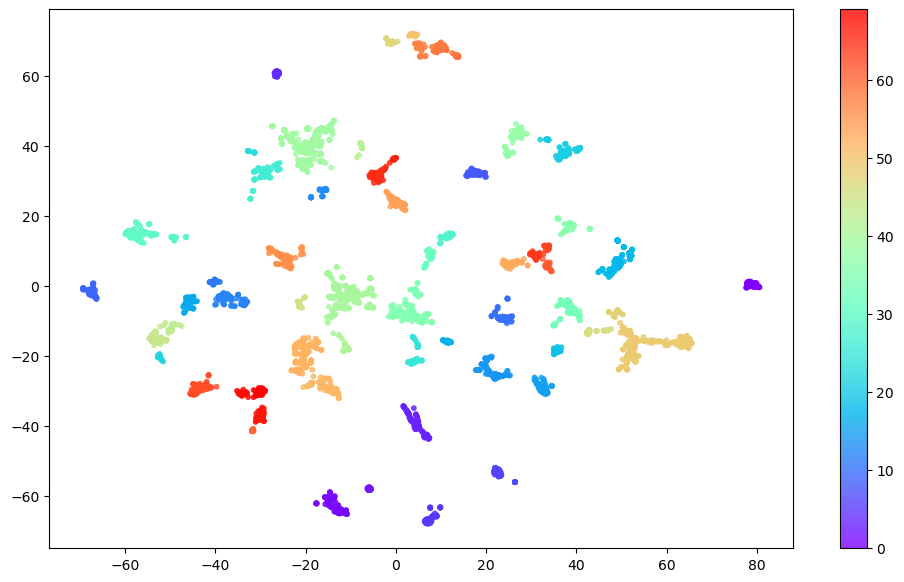

In [100]:
# Кластеризация с помощью HDBSCAN
clusterer_one = hdbscan.HDBSCAN(min_cluster_size=15)
clusters_tsne_hdbscan_one = clusterer_one.fit_predict(embeddings_tsne_one)

# Поиск индексов элементов, относящихся к кластеру -1
indices_to_keep = np.where(clusters_tsne_hdbscan_one != -1)[0]

# Фильтрация embeddings_tsne, оставляем только элементы, не относящиеся к кластеру -1
filtered_embeddings_tsne_one = embeddings_tsne_one[indices_to_keep]

# Визуализация результатов
plt.figure(figsize=(12, 7))
plt.scatter(filtered_embeddings_tsne_one[:, 0], filtered_embeddings_tsne_one[:, 1], c=clusters_tsne_hdbscan_one[indices_to_keep], cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

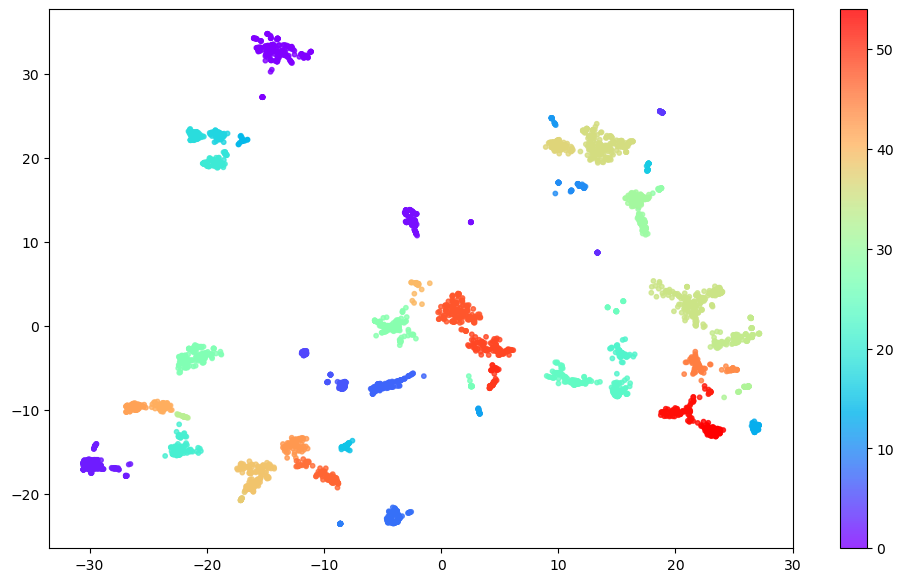

In [101]:
# Кластеризация с помощью HDBSCAN
clusterer_two = hdbscan.HDBSCAN(min_cluster_size=15)
clusters_tsne_hdbscan_two = clusterer_two.fit_predict(embeddings_tsne_two)

# Поиск индексов элементов, относящихся к кластеру -1
indices_to_keep = np.where(clusters_tsne_hdbscan_two != -1)[0]

# Фильтрация embeddings_tsne, оставляем только элементы, не относящиеся к кластеру -1
filtered_embeddings_tsne_two = embeddings_tsne_two[indices_to_keep]

# Визуализация результатов
plt.figure(figsize=(12, 7))
plt.scatter(filtered_embeddings_tsne_two[:, 0], filtered_embeddings_tsne_two[:, 1], c=clusters_tsne_hdbscan_two[indices_to_keep], cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

In [102]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

# Оценка стабильности кластеров
silhouette = silhouette_score(embeddings_tsne_one, clusters_tsne_hdbscan_one)
dbi = davies_bouldin_score(embeddings_tsne_one, clusters_tsne_hdbscan_one)
ari = adjusted_rand_score(clusters_tsne_hdbscan_one, clusters_tsne_hdbscan_two)  # Сравниваем кластеризацию с самой собой
ami = adjusted_mutual_info_score(clusters_tsne_hdbscan_one, clusters_tsne_hdbscan_two)  # Также сравниваем с самой собой

print(f'Silhouette Score: {silhouette}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {ari}')
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.4751163721084595
Индекс Дэвиса-Булдина: 1.27
Adjusted Rand Index: 0.4239496119219853
Adjusted Mutual Information: 0.8142658043335007


In [103]:
print(f'Silhouette Score: {format(round(silhouette, 2), ".2f")}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {round(ari, 2)}')
print(f'Adjusted Mutual Information: {round(ami, 2)}')

Silhouette Score: 0.48
Индекс Дэвиса-Булдина: 1.27
Adjusted Rand Index: 0.42
Adjusted Mutual Information: 0.81


#  Метод снижения размерности: метод главных компонент (Principal Component Analysis, PCA)

In [79]:
from sklearn.decomposition import PCA

# Создание объекта PCA с двумя компонентами
pca = PCA(n_components=2)

# Преобразование векторов embeddings_np в новое пространство меньшей размерности
embeddings_pca_one = pca.fit_transform(embeddings_np)

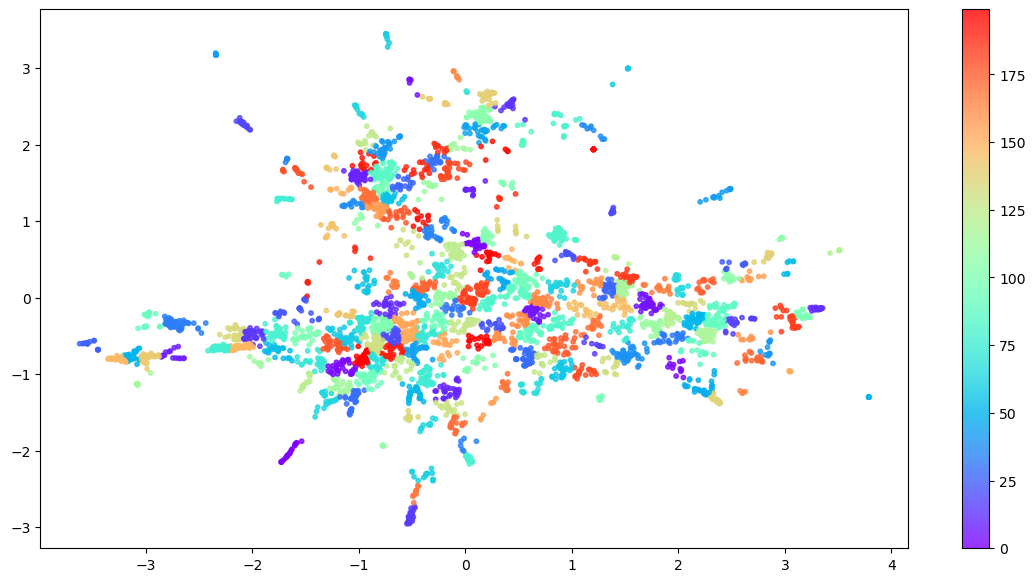

In [80]:
# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=200)  # Укажите желаемое количество кластеров
clusters_pca_one = kmeans.fit_predict(embeddings_pca_one)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(embeddings_pca_one[:, 0], embeddings_pca_one[:, 1], c=clusters_pca_one, cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

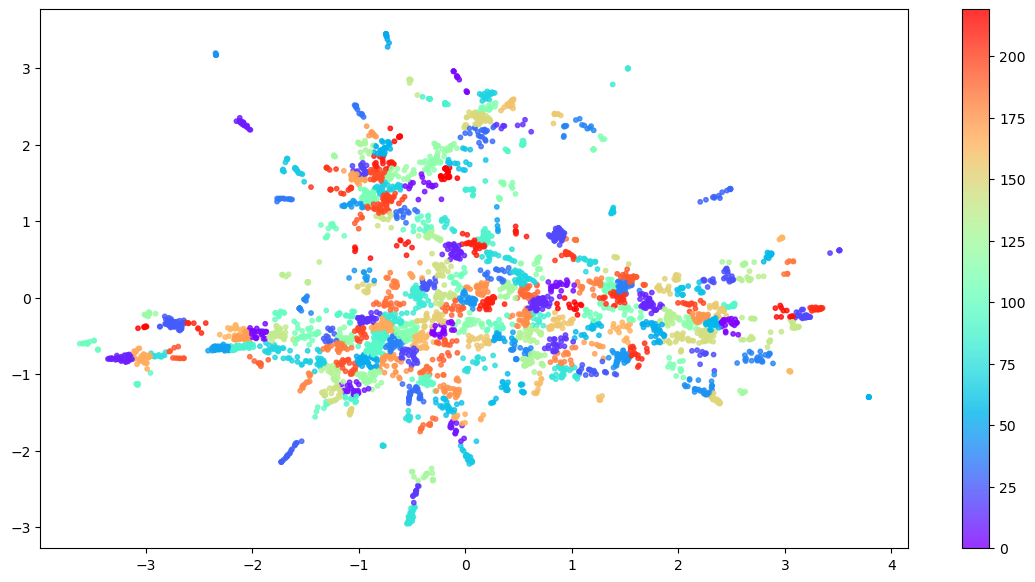

In [82]:
# Кластеризация с помощью K-Means
kmeans = KMeans(n_clusters=220)  # Укажите желаемое количество кластеров
clusters_pca_two = kmeans.fit_predict(embeddings_pca_one)

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.scatter(embeddings_pca_one[:, 0], embeddings_pca_one[:, 1], c=clusters_pca_two, cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

In [83]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import davies_bouldin_score

# Оценка стабильности кластеров
silhouette = silhouette_score(embeddings_pca_one, clusters_pca_one)
ari = adjusted_rand_score(clusters_pca_one, clusters_pca_two)  # Сравниваем кластеризацию с самой собой
dbi = davies_bouldin_score(embeddings_pca_one, clusters_pca_one)
ami = adjusted_mutual_info_score(clusters_pca_one, clusters_pca_two)  # Также сравниваем с самой собой

print(f'Silhouette Score: {silhouette}')
print(f"Индекс Дэвиса-Булдина: {dbi}")
print(f'Adjusted Rand Index: {ari}')
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.4650397002696991
Индекс Дэвиса-Булдина: 0.6596600863914043
Adjusted Rand Index: 0.703508755236821
Adjusted Mutual Information: 0.8651222110256822


In [84]:
print(f'Silhouette Score: {format(round(silhouette, 2), ".2f")}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {round(ari, 2)}')
print(f'Adjusted Mutual Information: {round(ami, 2)}')

Silhouette Score: 0.47
Индекс Дэвиса-Булдина: 0.66
Adjusted Rand Index: 0.7
Adjusted Mutual Information: 0.87


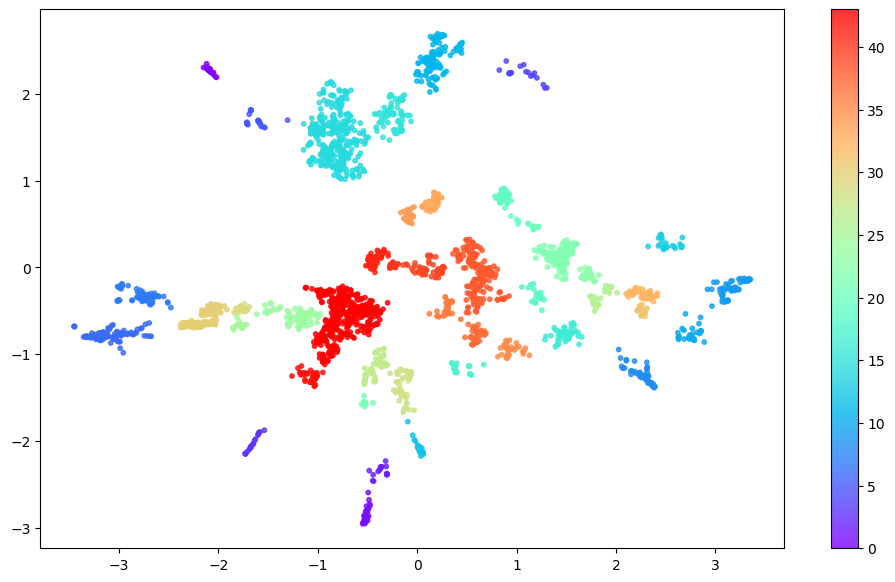

In [85]:
# Кластеризация с помощью HDBSCAN
clusterer_one = hdbscan.HDBSCAN(min_cluster_size=15)
clusters_pca_hdbscan_one = clusterer_one.fit_predict(embeddings_pca_one)

# Поиск индексов элементов, относящихся к кластеру -1
indices_to_keep = np.where(clusters_pca_hdbscan_one != -1)[0]

# Фильтрация embeddings_tsne, оставляем только элементы, не относящиеся к кластеру -1
filtered_embeddings_pca_one = embeddings_pca_one[indices_to_keep]

# Визуализация результатов
plt.figure(figsize=(12, 7))
plt.scatter(filtered_embeddings_pca_one[:, 0], filtered_embeddings_pca_one[:, 1], c=clusters_pca_hdbscan_one[indices_to_keep], cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

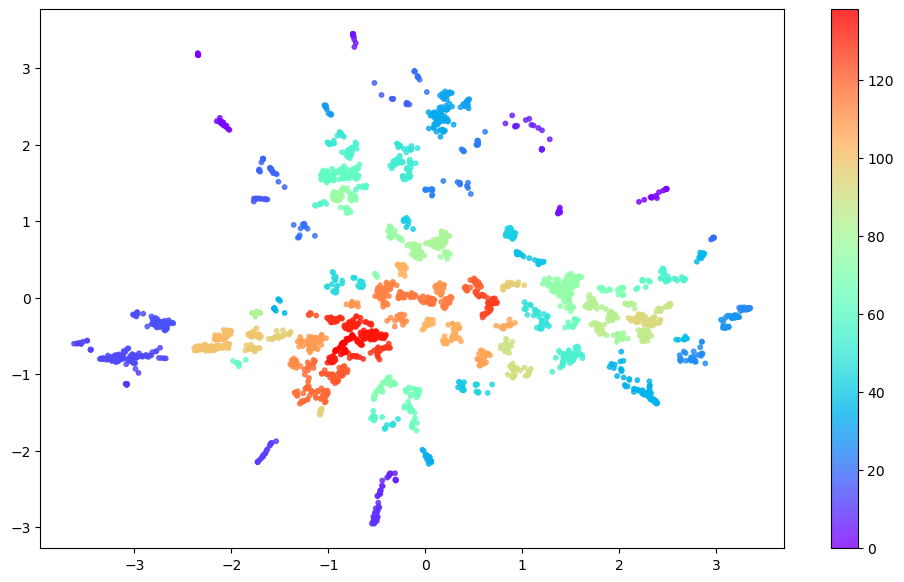

In [86]:
# Кластеризация с помощью HDBSCAN
clusterer_two = hdbscan.HDBSCAN(min_cluster_size=7)
clusters_pca_hdbscan_two = clusterer_two.fit_predict(embeddings_pca_one)

# Поиск индексов элементов, относящихся к кластеру -1
indices_to_keep = np.where(clusters_pca_hdbscan_two != -1)[0]

# Фильтрация embeddings_tsne, оставляем только элементы, не относящиеся к кластеру -1
filtered_embeddings_pca_two = embeddings_pca_one[indices_to_keep]

# Визуализация результатов
plt.figure(figsize=(12, 7))
plt.scatter(filtered_embeddings_pca_two[:, 0], filtered_embeddings_pca_two[:, 1], c=clusters_pca_hdbscan_two[indices_to_keep], cmap='rainbow', s=10, alpha=0.8)
plt.colorbar()
plt.show()

In [87]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import davies_bouldin_score

# Оценка стабильности кластеров
silhouette = silhouette_score(embeddings_pca_one, clusters_pca_hdbscan_one)
ari = adjusted_rand_score(clusters_pca_hdbscan_one, clusters_pca_hdbscan_two)  # Сравниваем кластеризацию с самой собой
dbi = davies_bouldin_score(embeddings_pca_one, clusters_pca_hdbscan_one)
ami = adjusted_mutual_info_score(clusters_pca_hdbscan_one, clusters_pca_hdbscan_two)  # Также сравниваем с самой собой

print(f'Silhouette Score: {silhouette}')
print(f'Adjusted Rand Index: {ari}')
print(f"Индекс Дэвиса-Булдина: {dbi}")
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.02318381704390049
Adjusted Rand Index: 0.2723640034616946
Индекс Дэвиса-Булдина: 1.7896614875936563
Adjusted Mutual Information: 0.5974747699848446


In [88]:
print(f'Silhouette Score: {format(round(silhouette, 2), ".2f")}')
print(f"Индекс Дэвиса-Булдина: {round(dbi, 2)}")
print(f'Adjusted Rand Index: {round(ari, 2)}')
print(f'Adjusted Mutual Information: {round(ami, 2)}')

Silhouette Score: 0.02
Индекс Дэвиса-Булдина: 1.79
Adjusted Rand Index: 0.27
Adjusted Mutual Information: 0.6
